<a href="https://colab.research.google.com/github/currencyfxjle/XGB2_CreditModeling_OverfittingOptimization/blob/main/XGB2_CreditModeling_OverfittingOptimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install piml

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.2/11.2 MB 48.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 39.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 533.5/533.5 kB 54.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 78.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 16.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 65.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 213.5/213.5 kB 28.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 98.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.6/34.6 MB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.9/22.9 MB 45.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.7/133.7 kB 20.3 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of ortools to determin

In [2]:
!pip install --upgrade cvxpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 32.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.7/227.7 kB 30.6 MB/s eta 0:00:00
  Attempting uninstall: cvxpy
    Found existing installation: cvxpy 1.3.2
    Uninstalling cvxpy-1.3.2:
      Successfully uninstalled cvxpy-1.3.2


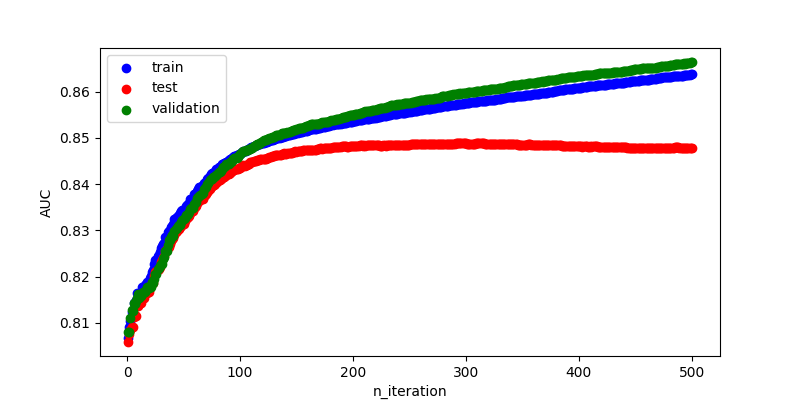

In [40]:
from piml import Experiment
import pandas as pd
import numpy as np
from matplotlib import pylab as plt
from sklearn.metrics import roc_auc_score
from piml.models import XGB2Classifier
from sklearn.model_selection import train_test_split

# Initialize a PiML Experiment
exp = Experiment(highcode_only=True)

# Load data, exclude demographic features and perform train-test split
data = pd.read_csv("https://github.com/SelfExplainML/PiML-Toolbox/blob/main/datasets/SimuCredit_v2.csv?raw=true")
exp.data_loader(data=data, silent=True)
exp.data_summary(feature_exclude=["Gender", "Race"], silent=True)
exp.data_prepare(test_ratio=0.2, random_state=0, silent=True)

# Manually creating a validation set from the training data
train_x, train_y, _ = exp.get_data(train=True)
train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=0.1, random_state=0)

# Fit a XGB2 model
# Depth of a Tree:
# The depth of a tree is the number of nodes from the root to the farthest leaf. A root node has a depth of 0.
# Control Overfitting:
# Deeper trees, which have more splits, allow the model to learn more complex patterns in the data.
# However, this can also lead to overfitting, where the model captures noise in the training data and performs poorly on unseen data.
# max_depth helps in controlling this aspect by limiting the depth of the trees.

model = XGB2Classifier(n_estimators=500, eta=0.05, max_depth=3)
exp.model_train(model, name='XGB')

# Function to score the model
def score(model, iteration_range):
    train_auc = roc_auc_score(train_y, model.predict_proba(train_x, iteration_range=iteration_range)[:, 1])
    test_auc = roc_auc_score(test_y, model.predict_proba(test_x, iteration_range=iteration_range)[:, 1])
    valid_auc = roc_auc_score(valid_y, model.predict_proba(valid_x, iteration_range=iteration_range)[:, 1])
    tree_idx = np.logical_and(xgbinfo["Tree"] < iteration_range[1], xgbinfo["Tree"] >= iteration_range[0])
    n_leaves = np.sum(xgbinfo[tree_idx].loc[:, ["Feature"]].values == "Leaf")
    return {'n_leaves': n_leaves, 'n_iteration': iteration_range[1], 'train_auc': train_auc, 'test_auc': test_auc, 'valid_auc': valid_auc}

# Prepare for early stopping
early_stopping_rounds = 50
best_iteration = 0
best_valid_auc = 0
all_metrics = []

model = exp.get_model("XGB").estimator.estimator_
xgbinfo = model.get_booster().trees_to_dataframe()
test_x, test_y, _ = exp.get_data(test=True)

# Iteratively evaLuate model and implement manual early stopping
for i in range(500):
    metrics = score(model, (0, i + 1))
    all_metrics.append(metrics)

    # Update best iteration based on validation AUC
    if metrics['valid_auc'] > best_valid_auc:
        best_valid_auc = metrics['valid_auc']
        best_iteration = i
    elif i - best_iteration > early_stopping_rounds:
        print(f"Early stopping at iteration {i}")
        break

# Create a DataFrame from the metrics and plot the results
all_results = pd.DataFrame(all_metrics)

plt.figure(figsize=(8, 4))
plt.scatter(all_results["n_iteration"], all_results["train_auc"], color="blue", label="train")
plt.scatter(all_results["n_iteration"], all_results["test_auc"], color="red", label="test")
plt.scatter(all_results["n_iteration"], all_results["valid_auc"], color="green", label="validation")
plt.legend()
plt.ylabel("AUC")
plt.xlabel("n_iteration")
plt.show()

**Hyperparameter Tuning Method:**

**First Code Snippet:** No explicit hyperparameter tuning is performed. The model is instantiated with fixed parameters (n_estimators=5000, eta=0.05, max_depth=2).

**Second Code Snippet:** Implements hyperparameter tuning using GridSearchCV for the max_depth parameter of the XGB2Classifier. Other parameters are set as n_estimators=5000 and eta=0.05. This approach systematically explores different configurations to find the best performing max_depth value.

Confusion Matrix:
 [[1283  525]
 [ 403 1789]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.76      0.71      0.73      1808
         1.0       0.77      0.82      0.79      2192

    accuracy                           0.77      4000
   macro avg       0.77      0.76      0.76      4000
weighted avg       0.77      0.77      0.77      4000



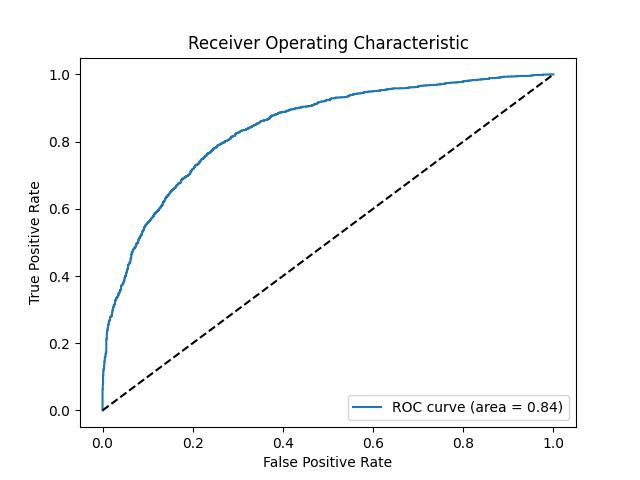

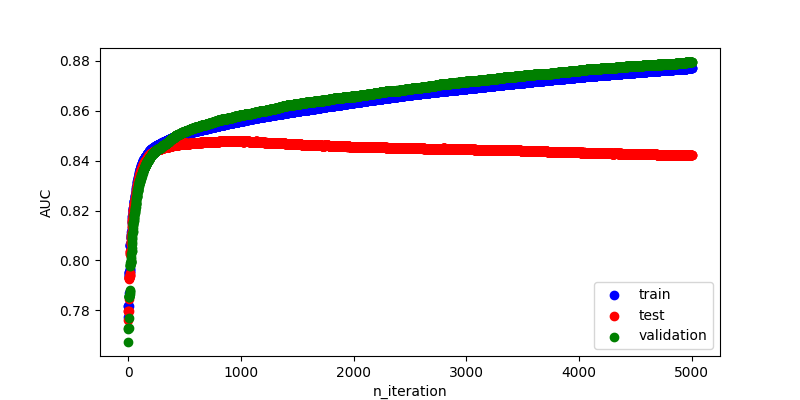

In [25]:
from piml import Experiment
import pandas as pd
import numpy as np
from matplotlib import pylab as plt
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, roc_curve, auc
from piml.models import XGB2Classifier
from sklearn.model_selection import train_test_split

# Initialize a PiML Experiment
exp = Experiment(highcode_only=True)

# Load data, exclude demographic features and perform train-test split
data = pd.read_csv("https://github.com/SelfExplainML/PiML-Toolbox/blob/main/datasets/SimuCredit_v2.csv?raw=true")
exp.data_loader(data=data, silent=True)
exp.data_summary(feature_exclude=["Gender", "Race"], silent=True)
exp.data_prepare(test_ratio=0.2, random_state=0, silent=True)

# Manually creating a validation set from the training data
train_x, train_y, _ = exp.get_data(train=True)
train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=0.1, random_state=0)

# Fit a XGB2 model
model = XGB2Classifier(n_estimators=5000, eta=0.05, max_depth=2)
exp.model_train(model, name='XGB')

# Function to score the model
def score(model, iteration_range):
    train_auc = roc_auc_score(train_y, model.predict_proba(train_x, iteration_range=iteration_range)[:, 1])
    test_auc = roc_auc_score(test_y, model.predict_proba(test_x, iteration_range=iteration_range)[:, 1])
    valid_auc = roc_auc_score(valid_y, model.predict_proba(valid_x, iteration_range=iteration_range)[:, 1])
    tree_idx = np.logical_and(xgbinfo["Tree"] < iteration_range[1], xgbinfo["Tree"] >= iteration_range[0])
    n_leaves = np.sum(xgbinfo[tree_idx].loc[:, ["Feature"]].values == "Leaf")
    return {'n_leaves': n_leaves, 'n_iteration': iteration_range[1], 'train_auc': train_auc, 'test_auc': test_auc, 'valid_auc': valid_auc}

# Prepare for early stopping
early_stopping_rounds = 50
best_iteration = 0
best_valid_auc = 0
all_metrics = []
model = exp.get_model("XGB").estimator.estimator_
xgbinfo = model.get_booster().trees_to_dataframe()
test_x, test_y, _ = exp.get_data(test=True)

# Iteratively evaluate model and implement manual early stopping
for i in range(5000):
    metrics = score(model, (0, i + 1))
    all_metrics.append(metrics)

    # Update best iteration based on validation AUC
    if metrics['valid_auc'] > best_valid_auc:
        best_valid_auc = metrics['valid_auc']
        best_iteration = i
    elif i - best_iteration > early_stopping_rounds:
        print(f"Early stopping at iteration {i}")
        break

# Evaluation on the test set
y_pred = model.predict(test_x)
y_pred_proba = model.predict_proba(test_x)[:, 1]

# Confusion matrix
cm = confusion_matrix(test_y, y_pred)
print("Confusion Matrix:\n", cm)

# Classification report for precision, recall, F1-score
print("\nClassification Report:\n", classification_report(test_y, y_pred))

# ROC Curve and AUC
fpr, tpr, _ = roc_curve(test_y, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Plotting AUC over iterations
all_results = pd.DataFrame(all_metrics)
plt.figure(figsize=(8, 4))
plt.scatter(all_results["n_iteration"], all_results["train_auc"], color="blue", label="train")
plt.scatter(all_results["n_iteration"], all_results["test_auc"], color="red", label="test")
plt.scatter(all_results["n_iteration"], all_results["valid_auc"], color="green", label="validation")
plt.legend()
plt.ylabel("AUC")
plt.xlabel("n_iteration")
plt.show()


**Hyperparameter Tunning**

In [4]:
# Print all attributes and methods of the XGB2Classifier object
print(dir(model))

# Look for an attribute or method that seems like it would return the underlying booster or XGBoost model
# This step depends on what you find from the above command


['X_', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getstate__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__setstate__', '__sizeof__', '__sklearn_is_fitted__', '__str__', '__subclasshook__', '__weakref__', '_base_extract_rules', '_check_feature_names', '_check_n_features', '_estimator_type', '_fit_xgb_raw', '_get_param_names', '_get_tags', '_more_tags', '_repr_html_', '_repr_html_inner', '_repr_mimebundle_', '_validate_data', '_validate_input', '_validate_params', 'classes_', 'decision_function', 'estimator_', 'eta', 'feature_names', 'feature_names_', 'feature_types', 'feature_types_', 'fit', 'gamma', 'get_params', 'is_fitted_', 'label_binarizer_', 'max_bin', 'max_depth', 'mono_decreasing_list', 'mono_increasing_list', 'n_estimators', 'n_features_in_', 'parse_model', 'partial_dependence'

Best gamma (regularization): 0.5
Best max_depth: 3


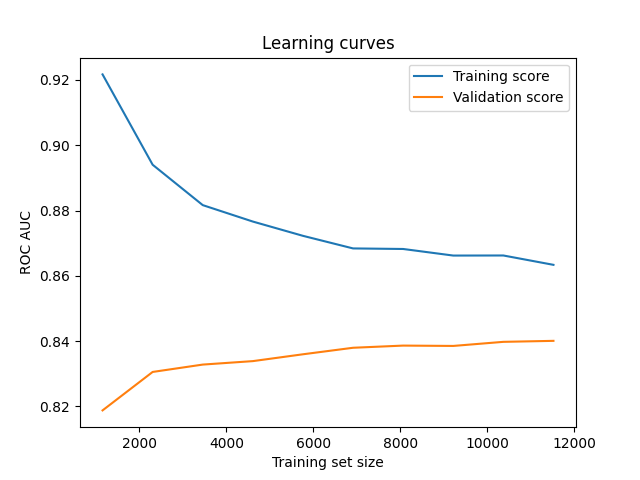

Early stopping at iteration 51
Confusion Matrix:
 [[1279  529]
 [ 412 1780]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.76      0.71      0.73      1808
         1.0       0.77      0.81      0.79      2192

    accuracy                           0.76      4000
   macro avg       0.76      0.76      0.76      4000
weighted avg       0.76      0.76      0.76      4000



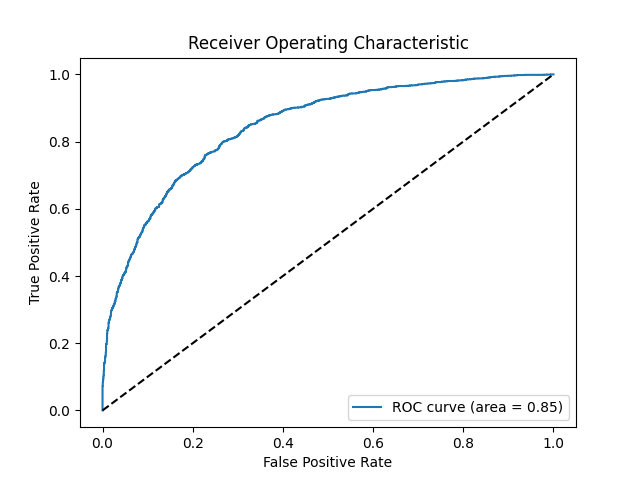

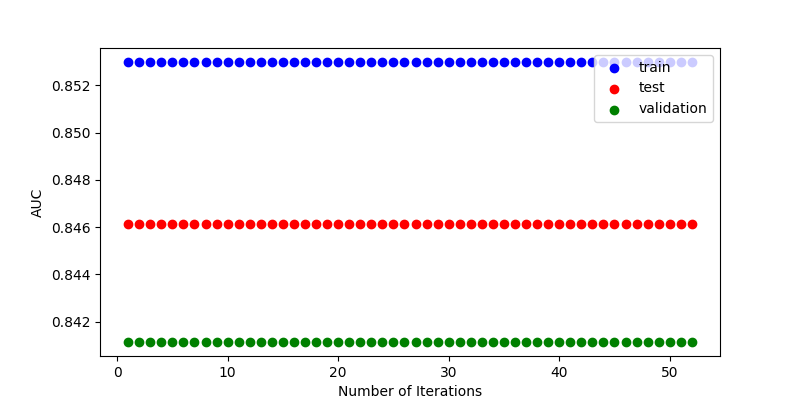

Cross-validation ROC AUC scores: [0.83451997 0.83266232 0.84827417 0.83591241 0.84646432]


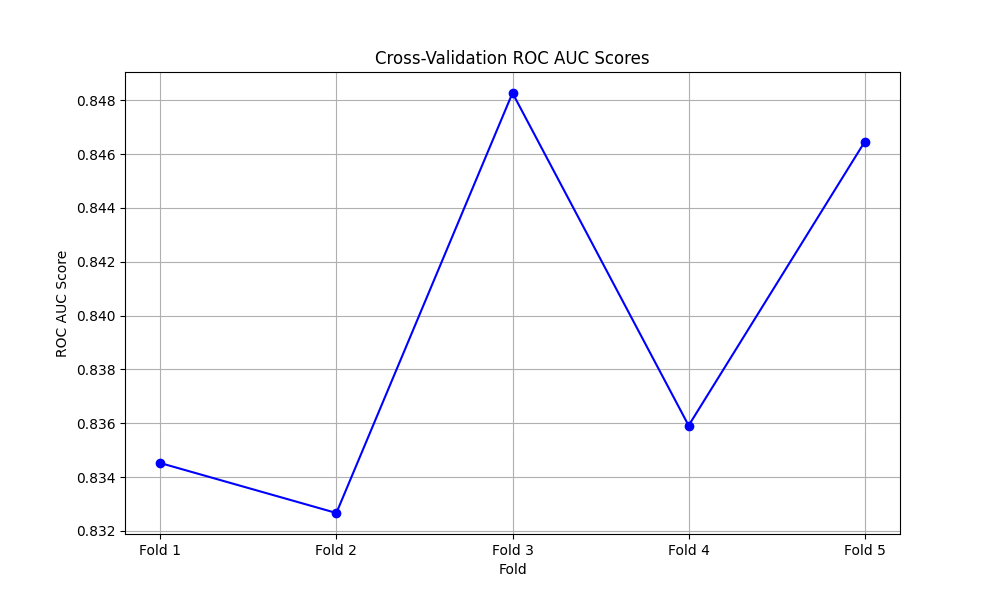

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, cross_val_score
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, roc_curve, auc
from piml import Experiment
from piml.models import XGB2Classifier

# Initialize a PiML Experiment
exp = Experiment(highcode_only=True)

# Load data, exclude demographic features, and perform train-test split
data_url = "https://github.com/SelfExplainML/PiML-Toolbox/blob/main/datasets/SimuCredit_v2.csv?raw=true"
data = pd.read_csv(data_url)
exp.data_loader(data=data, silent=True)
exp.data_summary(feature_exclude=["Gender", "Race"], silent=True)
exp.data_prepare(test_ratio=0.2, random_state=0, silent=True)

# Retrieve training and test data
train_x, train_y, _ = exp.get_data(train=True)
test_x, test_y, _ = exp.get_data(test=True)

# Optionally, create a validation set from the training data
train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=0.1, random_state=0)

# Instantiate the XGB2 model
model = XGB2Classifier(n_estimators=5000, eta=0.05)

# Function to plot learning curves
def plot_learning_curves(model, X, y, train_sizes=np.linspace(0.1, 1.0, 10)):
    train_sizes, train_scores, validation_scores = learning_curve(
        model, X, y, train_sizes=train_sizes, cv=5, scoring='roc_auc')

    train_scores_mean = np.mean(train_scores, axis=1)
    validation_scores_mean = np.mean(validation_scores, axis=1)

    plt.figure()
    plt.plot(train_sizes, train_scores_mean, label='Training score')
    plt.plot(train_sizes, validation_scores_mean, label='Validation score')
    plt.ylabel('ROC AUC')
    plt.xlabel('Training set size')
    plt.title('Learning curves')
    plt.legend()
    plt.show()

# Hyperparameter grid for regularization ('gamma') and 'max_depth'
hyperparameter_grid = {
    'gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5],
    'max_depth': [3, 4, 5, 6, 7, 8]
}

# GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(model, hyperparameter_grid, scoring='roc_auc', cv=5)
grid_search.fit(train_x, train_y)

# Best gamma and max_depth parameters
best_gamma = grid_search.best_params_['gamma']
best_max_depth = grid_search.best_params_['max_depth']
print("Best gamma (regularization):", best_gamma)
print("Best max_depth:", best_max_depth)

# Use the best model from GridSearchCV for further steps
model = grid_search.best_estimator_

# Plot learning curves using the tuned model
plot_learning_curves(model, train_x, train_y)

# Re-fit the model with the best regularization parameter
model = XGB2Classifier(n_estimators=5000, eta=0.05, gamma=best_gamma)
model.fit(train_x, train_y)

# Function to score the model
def score(model, train_x, train_y, test_x, test_y, valid_x, valid_y):
    train_auc = roc_auc_score(train_y, model.predict_proba(train_x)[:, 1])
    test_auc = roc_auc_score(test_y, model.predict_proba(test_x)[:, 1])
    valid_auc = roc_auc_score(valid_y, model.predict_proba(valid_x)[:, 1])

    # Access the underlying XGBoost booster
    booster = model.estimator_.get_booster()
    xgbinfo = booster.trees_to_dataframe()

    # Calculate the number of leaves
    n_leaves = np.sum(xgbinfo.loc[:, ["Feature"]].values == "Leaf")
    return {'train_auc': train_auc, 'test_auc': test_auc, 'valid_auc': valid_auc, 'n_leaves': n_leaves}

# Prepare for early stopping and data collection for plot
early_stopping_rounds = 50
best_iteration = 0
best_valid_auc = 0
all_metrics = []

# Iteratively evaluate model and implement manual early stopping
for i in range(5000):
    metrics = score(model, train_x, train_y, test_x, test_y, valid_x, valid_y)
    metrics['n_iteration'] = i + 1
    all_metrics.append(metrics)

    if metrics['valid_auc'] > best_valid_auc:
        best_valid_auc = metrics['valid_auc']
        best_iteration = i
    elif i - best_iteration > early_stopping_rounds:
        print(f"Early stopping at iteration {i}")
        break

# Evaluation on the test set
y_pred = model.predict(test_x)
y_pred_proba = model.predict_proba(test_x)[:, 1]

# Confusion matrix
cm = confusion_matrix(test_y, y_pred)
print("Confusion Matrix:\n", cm)

# Classification report for precision, recall, F1-score
print("\nClassification Report:\n", classification_report(test_y, y_pred))

# ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(test_y, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Plotting AUC over iterations
all_results = pd.DataFrame(all_metrics)
plt.figure(figsize=(8, 4))
plt.scatter(all_results["n_iteration"], all_results["train_auc"], color="blue", label="train")
plt.scatter(all_results["n_iteration"], all_results["test_auc"], color="red", label="test")
plt.scatter(all_results["n_iteration"], all_results["valid_auc"], color="green", label="validation")
plt.legend()
plt.ylabel("AUC")
plt.xlabel("Number of Iterations")
plt.show()

# Cross-validation scores
cross_val_scores = cross_val_score(model, train_x, train_y, cv=5, scoring='roc_auc')
print("Cross-validation ROC AUC scores:", cross_val_scores)

# Plotting the cross-validation scores
plt.figure(figsize=(10, 6))
plt.plot(cross_val_scores, marker='o', linestyle='-', color='b')
plt.title('Cross-Validation ROC AUC Scores')
plt.xlabel('Fold')
plt.ylabel('ROC AUC Score')
plt.xticks(range(len(cross_val_scores)), [f"Fold {i+1}" for i in range(len(cross_val_scores))])
plt.grid(True)
plt.show()

Best Parameters Found by GridSearchCV:
{'gamma': 0.4, 'max_depth': 5, 'reg_alpha': 0, 'reg_lambda': 3}


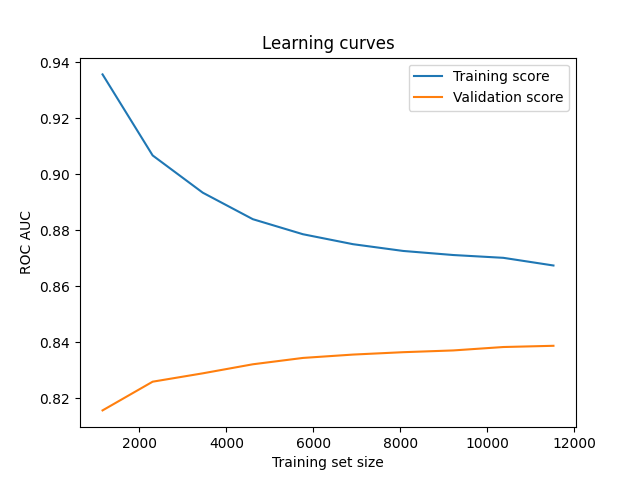

Early stopping at iteration 51
Confusion Matrix:
 [[1279  529]
 [ 412 1780]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.76      0.71      0.73      1808
         1.0       0.77      0.81      0.79      2192

    accuracy                           0.76      4000
   macro avg       0.76      0.76      0.76      4000
weighted avg       0.76      0.76      0.76      4000



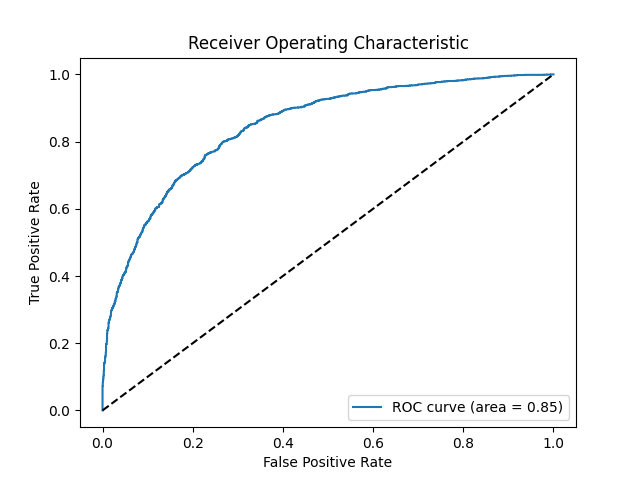

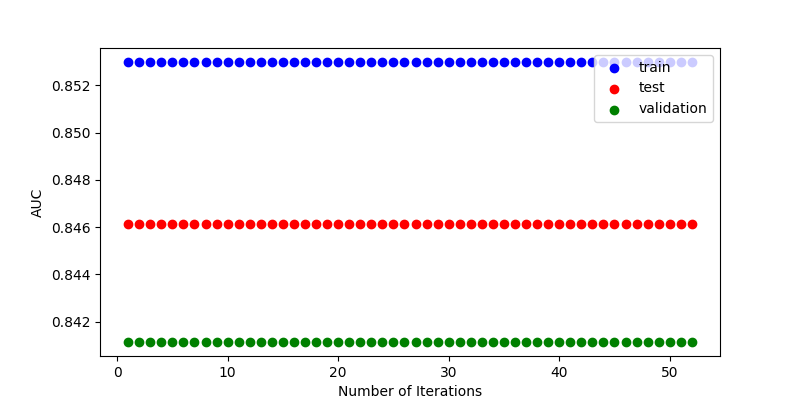

Cross-validation ROC AUC scores: [0.83451997 0.83266232 0.84827417 0.83591241 0.84646432]


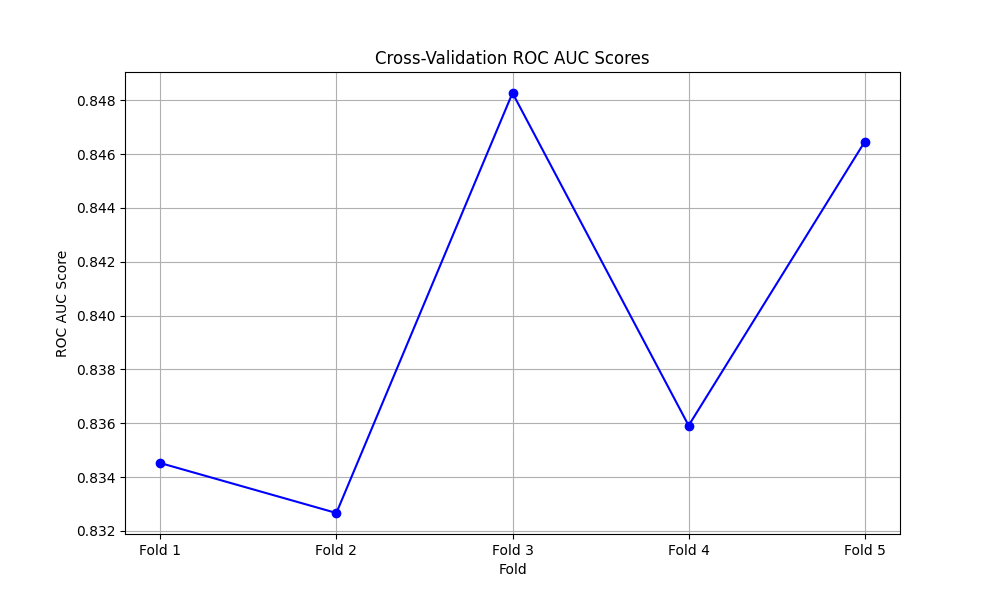

In [39]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, cross_val_score
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, roc_curve, auc
from piml import Experiment
from piml.models import XGB2Classifier

# Initialize a PiML Experiment
exp = Experiment(highcode_only=True)

# Load data, exclude demographic features, and perform train-test split
data_url = "https://github.com/SelfExplainML/PiML-Toolbox/blob/main/datasets/SimuCredit_v2.csv?raw=true"
data = pd.read_csv(data_url)
exp.data_loader(data=data, silent=True)
exp.data_summary(feature_exclude=["Gender", "Race"], silent=True)
exp.data_prepare(test_ratio=0.2, random_state=0, silent=True)

# Retrieve training and test data
train_x, train_y, _ = exp.get_data(train=True)
test_x, test_y, _ = exp.get_data(test=True)

# Optionally, create a validation set from the training data
train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=0.1, random_state=0)

# Instantiate the XGB2 model
model = XGB2Classifier(n_estimators=100, eta=0.05)

# Function to plot learning curves
def plot_learning_curves(model, X, y, train_sizes=np.linspace(0.1, 1.0, 10)):
    train_sizes, train_scores, validation_scores = learning_curve(
        model, X, y, train_sizes=train_sizes, cv=5, scoring='roc_auc')

    train_scores_mean = np.mean(train_scores, axis=1)
    validation_scores_mean = np.mean(validation_scores, axis=1)

    plt.figure()
    plt.plot(train_sizes, train_scores_mean, label='Training score')
    plt.plot(train_sizes, validation_scores_mean, label='Validation score')
    plt.ylabel('ROC AUC')
    plt.xlabel('Training set size')
    plt.title('Learning curves')
    plt.legend()
    plt.show()

# Hyperparameter grid for regularization ('gamma', 'reg_alpha', 'reg_lambda') and 'max_depth'
hyperparameter_grid = {
    'gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5],
    'max_depth': [3, 4, 5, 6, 7, 8],
    'reg_alpha': [0, 0.001, 0.005, 0.01, 0.05],  # L1 regularization
    'reg_lambda': [1, 1.5, 2, 3, 4.5]           # L2 regularization
}

# GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(model, hyperparameter_grid, scoring='roc_auc', cv=5)
grid_search.fit(train_x, train_y)

# Print the best parameters
best_params = grid_search.best_params_
print("Best Parameters Found by GridSearchCV:")
print(best_params)

# Use the best parameters for your model
model = XGB2Classifier(n_estimators=100, eta=0.05, **best_params)
model.fit(train_x, train_y)

# Plot learning curves using the tuned model
plot_learning_curves(model, train_x, train_y)

# Re-fit the model with the best regularization parameter
model = XGB2Classifier(n_estimators=5000, eta=0.05, gamma=best_gamma)
model.fit(train_x, train_y)

# Function to score the model
def score(model, train_x, train_y, test_x, test_y, valid_x, valid_y):
    train_auc = roc_auc_score(train_y, model.predict_proba(train_x)[:, 1])
    test_auc = roc_auc_score(test_y, model.predict_proba(test_x)[:, 1])
    valid_auc = roc_auc_score(valid_y, model.predict_proba(valid_x)[:, 1])

    # Access the underlying XGBoost booster
    booster = model.estimator_.get_booster()
    xgbinfo = booster.trees_to_dataframe()

    # Calculate the number of leaves
    n_leaves = np.sum(xgbinfo.loc[:, ["Feature"]].values == "Leaf")
    return {'train_auc': train_auc, 'test_auc': test_auc, 'valid_auc': valid_auc, 'n_leaves': n_leaves}

# Prepare for early stopping and data collection for plot
early_stopping_rounds = 50
best_iteration = 0
best_valid_auc = 0
all_metrics = []

# Iteratively evaluate model and implement manual early stopping
for i in range(100):
    metrics = score(model, train_x, train_y, test_x, test_y, valid_x, valid_y)
    metrics['n_iteration'] = i + 1
    all_metrics.append(metrics)

    if metrics['valid_auc'] > best_valid_auc:
        best_valid_auc = metrics['valid_auc']
        best_iteration = i
    elif i - best_iteration > early_stopping_rounds:
        print(f"Early stopping at iteration {i}")
        break

# Evaluation on the test set
y_pred = model.predict(test_x)
y_pred_proba = model.predict_proba(test_x)[:, 1]

# Confusion matrix
cm = confusion_matrix(test_y, y_pred)
print("Confusion Matrix:\n", cm)

# Classification report for precision, recall, F1-score
print("\nClassification Report:\n", classification_report(test_y, y_pred))

# ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(test_y, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Plotting AUC over iterations
all_results = pd.DataFrame(all_metrics)
plt.figure(figsize=(8, 4))
plt.scatter(all_results["n_iteration"], all_results["train_auc"], color="blue", label="train")
plt.scatter(all_results["n_iteration"], all_results["test_auc"], color="red", label="test")
plt.scatter(all_results["n_iteration"], all_results["valid_auc"], color="green", label="validation")
plt.legend()
plt.ylabel("AUC")
plt.xlabel("Number of Iterations")
plt.show()

# Cross-validation scores
cross_val_scores = cross_val_score(model, train_x, train_y, cv=5, scoring='roc_auc')
print("Cross-validation ROC AUC scores:", cross_val_scores)

# Plotting the cross-validation scores
plt.figure(figsize=(10, 6))
plt.plot(cross_val_scores, marker='o', linestyle='-', color='b')
plt.title('Cross-Validation ROC AUC Scores')
plt.xlabel('Fold')
plt.ylabel('ROC AUC Score')
plt.xticks(range(len(cross_val_scores)), [f"Fold {i+1}" for i in range(len(cross_val_scores))])
plt.grid(True)
plt.show()

Model: Extensive Hyperparameter Tuning and Model Evaluation

**Hyperparameter Tuning:**

Uses GridSearchCV for systematic hyperparameter tuning.
Explores a combination of gamma, max_depth, reg_alpha, and reg_lambda parameters.
Determines the best combination of these parameters for model performance.
Model Evaluation:

Includes learning curve analysis to understand model performance relative to the size of the training set.
Implements manual early stopping based on validation AUC to prevent overfitting.
Evaluates the model iteratively over 5000 iterations.
Uses cross-validation scores to assess the model's generalization capability.
Provides a detailed analysis with confusion matrix, classification report, and ROC curve.

**Overall Approach:**

More comprehensive in terms of exploring model complexity and preventing overfitting.
Focuses on both model performance and generalizability.
Model 2: Focused Model Training and Evaluation
Hyperparameter Tuning:

No systematic grid search for hyperparameter tuning.
The model is trained with predefined hyperparameters (n_estimators, eta, max_depth).

**Model Evaluation:**

Uses a custom scoring function that provides additional insights (e.g., number of leaves) alongside traditional metrics.
Implements manual early stopping over 500 iterations.
Does not include cross-validation or learning curve analysis.

**Overall Approach:**

- More focused on specific model aspects (like tree complexity through n_leaves).

- Less comprehensive in terms of hyperparameter exploration.
Emphasizes quick assessment and stopping based on early performance indications.

**Key Differences:**

Hyperparameter Tuning: The first model uses GridSearchCV for an extensive search of the best parameters, while the second model directly sets specific hyperparameters without a systematic search.

**Model Evaluation:**

The first model uses a range of evaluation techniques, including learning curves and cross-validation, providing a broader assessment of the model. The second model focuses on early stopping and custom metrics like the number of leaves, offering a more specific but less comprehensive evaluation.

Iteration Range: The first model evaluates over a broader range of iterations (5000), potentially capturing more nuances in performance changes. The second model limits itself to 500 iterations, emphasizing quicker evaluation.

**Depth of Analysis:**

The first model offers a deeper and more holistic analysis (including learning curves and cross-validation), whereas the second is more streamlined and focused on specific aspects of model performance.

**In summary,** the Hyperparameter model is more thorough and expansive in its approach, suitable for scenarios where fine-tuning and comprehensive evaluation are crucial. The second model, on the other hand, is more streamlined, focusing on specific aspects of the model and quicker evaluation, which might be preferred in situations requiring rapid model development and deployment.

Best gamma (regularization): 0.5
Best max_depth: 3


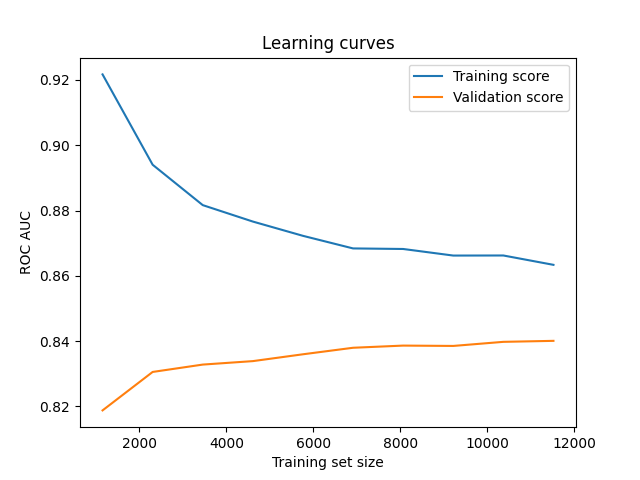

Confusion Matrix:
 [[1279  529]
 [ 412 1780]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.76      0.71      0.73      1808
         1.0       0.77      0.81      0.79      2192

    accuracy                           0.76      4000
   macro avg       0.76      0.76      0.76      4000
weighted avg       0.76      0.76      0.76      4000



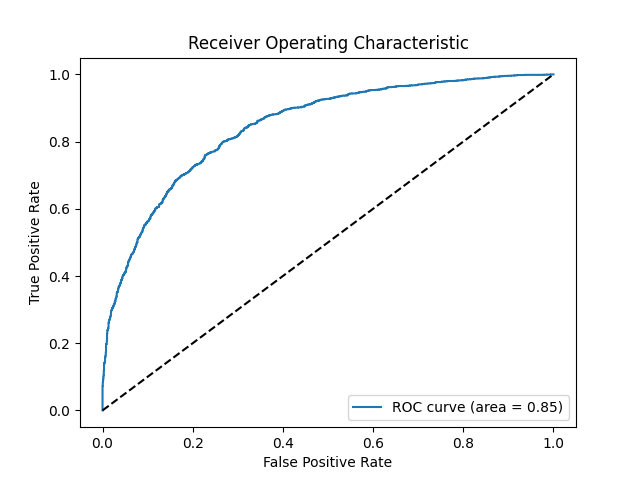

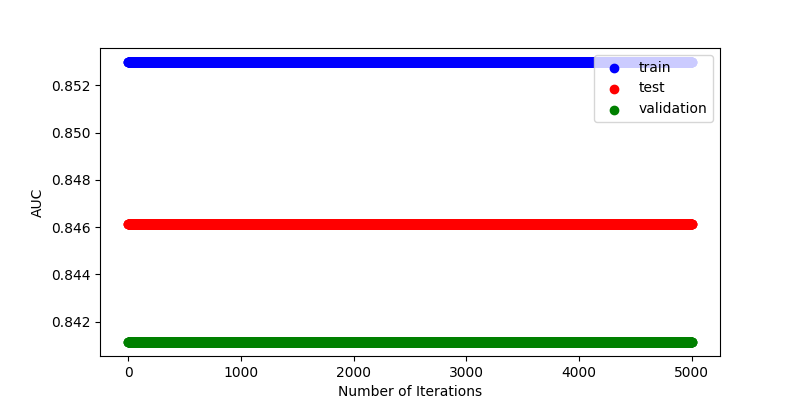

Cross-validation ROC AUC scores: [0.83451997 0.83266232 0.84827417 0.83591241 0.84646432]


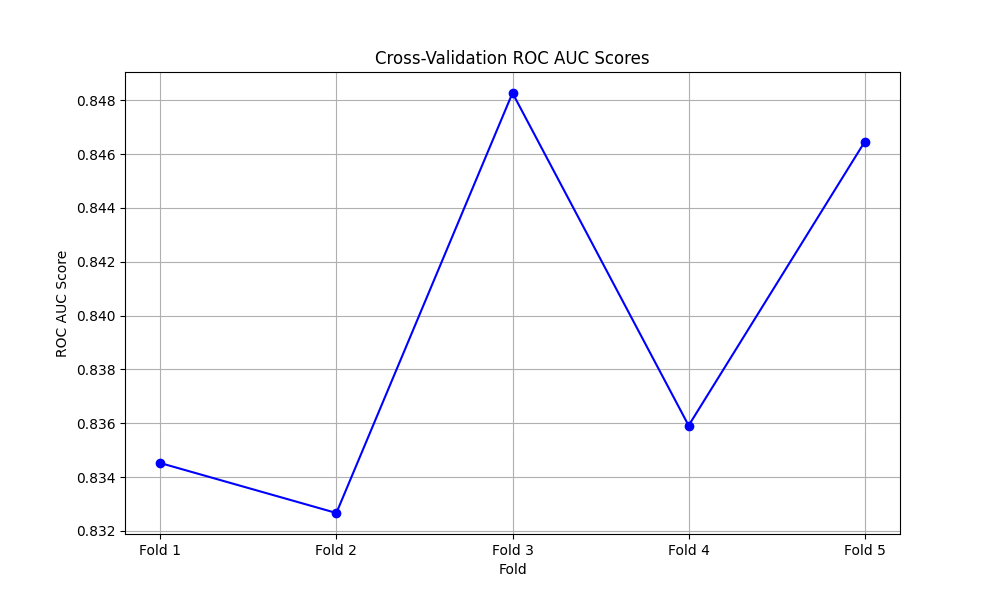

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, cross_val_score
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, roc_curve, auc
from piml import Experiment
from piml.models import XGB2Classifier

# Initialize a PiML Experiment
exp = Experiment(highcode_only=True)

# Load data, exclude demographic features, and perform train-test split
data_url = "https://github.com/SelfExplainML/PiML-Toolbox/blob/main/datasets/SimuCredit_v2.csv?raw=true"
data = pd.read_csv(data_url)
exp.data_loader(data=data, silent=True)
exp.data_summary(feature_exclude=["Gender", "Race"], silent=True)
exp.data_prepare(test_ratio=0.2, random_state=0, silent=True)

# Retrieve training and test data
train_x, train_y, _ = exp.get_data(train=True)
test_x, test_y, _ = exp.get_data(test=True)

# Optionally, create a validation set from the training data
train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=0.1, random_state=0)

# Instantiate the XGB2 model
model = XGB2Classifier(n_estimators=5000, eta=0.05)

# Function to plot learning curves
def plot_learning_curves(model, X, y, train_sizes=np.linspace(0.1, 1.0, 10)):
    train_sizes, train_scores, validation_scores = learning_curve(
        model, X, y, train_sizes=train_sizes, cv=5, scoring='roc_auc')

    train_scores_mean = np.mean(train_scores, axis=1)
    validation_scores_mean = np.mean(validation_scores, axis=1)

    plt.figure()
    plt.plot(train_sizes, train_scores_mean, label='Training score')
    plt.plot(train_sizes, validation_scores_mean, label='Validation score')
    plt.ylabel('ROC AUC')
    plt.xlabel('Training set size')
    plt.title('Learning curves')
    plt.legend()
    plt.show()

# Hyperparameter grid for regularization ('gamma') and 'max_depth'
hyperparameter_grid = {
    'gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5],
    'max_depth': [3, 4, 5, 6, 7, 8]
}

# GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(model, hyperparameter_grid, scoring='roc_auc', cv=5)
grid_search.fit(train_x, train_y)

# Best gamma and max_depth parameters
best_gamma = grid_search.best_params_['gamma']
best_max_depth = grid_search.best_params_['max_depth']
print("Best gamma (regularization):", best_gamma)
print("Best max_depth:", best_max_depth)

# Use the best model from GridSearchCV for further steps
model = grid_search.best_estimator_

# Plot learning curves using the tuned model
plot_learning_curves(model, train_x, train_y)

# Re-fit the model with the best regularization parameter
model = XGB2Classifier(n_estimators=5000, eta=0.05, gamma=best_gamma)
model.fit(train_x, train_y)

# Function to score the model
def score(model, train_x, train_y, test_x, test_y, valid_x, valid_y):
    train_auc = roc_auc_score(train_y, model.predict_proba(train_x)[:, 1])
    test_auc = roc_auc_score(test_y, model.predict_proba(test_x)[:, 1])
    valid_auc = roc_auc_score(valid_y, model.predict_proba(valid_x)[:, 1])

    # Access the underlying XGBoost booster
    booster = model.estimator_.get_booster()
    xgbinfo = booster.trees_to_dataframe()

    # Calculate the number of leaves
    n_leaves = np.sum(xgbinfo.loc[:, ["Feature"]].values == "Leaf")
    return {'train_auc': train_auc, 'test_auc': test_auc, 'valid_auc': valid_auc, 'n_leaves': n_leaves}

# Prepare for early stopping and data collection for plot
early_stopping_rounds = 5000
best_iteration = 0
best_valid_auc = 0
all_metrics = []

# Iteratively evaluate model and implement manual early stopping
for i in range(5000):
    metrics = score(model, train_x, train_y, test_x, test_y, valid_x, valid_y)
    metrics['n_iteration'] = i + 1
    all_metrics.append(metrics)

    if metrics['valid_auc'] > best_valid_auc:
        best_valid_auc = metrics['valid_auc']
        best_iteration = i
    elif i - best_iteration > early_stopping_rounds:
        print(f"Early stopping at iteration {i}")
        break

# Evaluation on the test set
y_pred = model.predict(test_x)
y_pred_proba = model.predict_proba(test_x)[:, 1]

# Confusion matrix
cm = confusion_matrix(test_y, y_pred)
print("Confusion Matrix:\n", cm)

# Classification report for precision, recall, F1-score
print("\nClassification Report:\n", classification_report(test_y, y_pred))

# ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(test_y, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Plotting AUC over iterations
all_results = pd.DataFrame(all_metrics)
plt.figure(figsize=(8, 4))
plt.scatter(all_results["n_iteration"], all_results["train_auc"], color="blue", label="train")
plt.scatter(all_results["n_iteration"], all_results["test_auc"], color="red", label="test")
plt.scatter(all_results["n_iteration"], all_results["valid_auc"], color="green", label="validation")
plt.legend()
plt.ylabel("AUC")
plt.xlabel("Number of Iterations")
plt.show()

# Cross-validation scores
cross_val_scores = cross_val_score(model, train_x, train_y, cv=5, scoring='roc_auc')
print("Cross-validation ROC AUC scores:", cross_val_scores)

# Plotting the cross-validation scores
plt.figure(figsize=(10, 6))
plt.plot(cross_val_scores, marker='o', linestyle='-', color='b')
plt.title('Cross-Validation ROC AUC Scores')
plt.xlabel('Fold')
plt.ylabel('ROC AUC Score')
plt.xticks(range(len(cross_val_scores)), [f"Fold {i+1}" for i in range(len(cross_val_scores))])
plt.grid(True)
plt.show()

Best gamma (regularization): 0.5
Best max_depth: 3


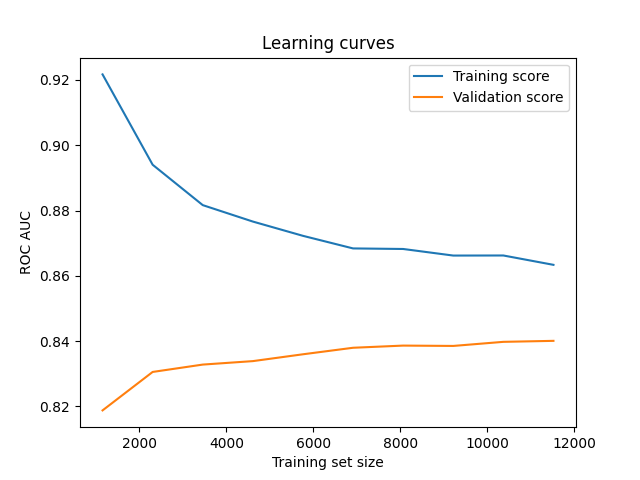

Early stopping at iteration 51
Confusion Matrix:
 [[1279  529]
 [ 412 1780]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.76      0.71      0.73      1808
         1.0       0.77      0.81      0.79      2192

    accuracy                           0.76      4000
   macro avg       0.76      0.76      0.76      4000
weighted avg       0.76      0.76      0.76      4000



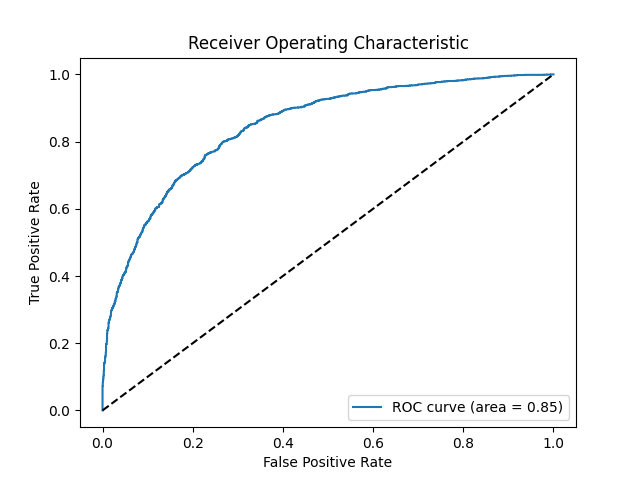

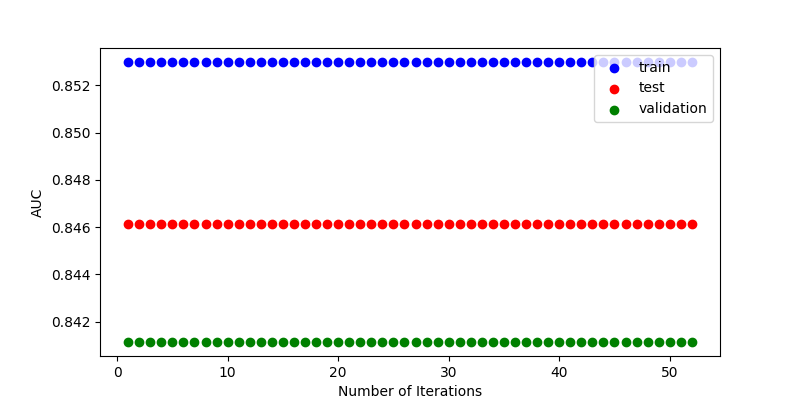

Cross-validation ROC AUC scores: [0.83451997 0.83266232 0.84827417 0.83591241 0.84646432]


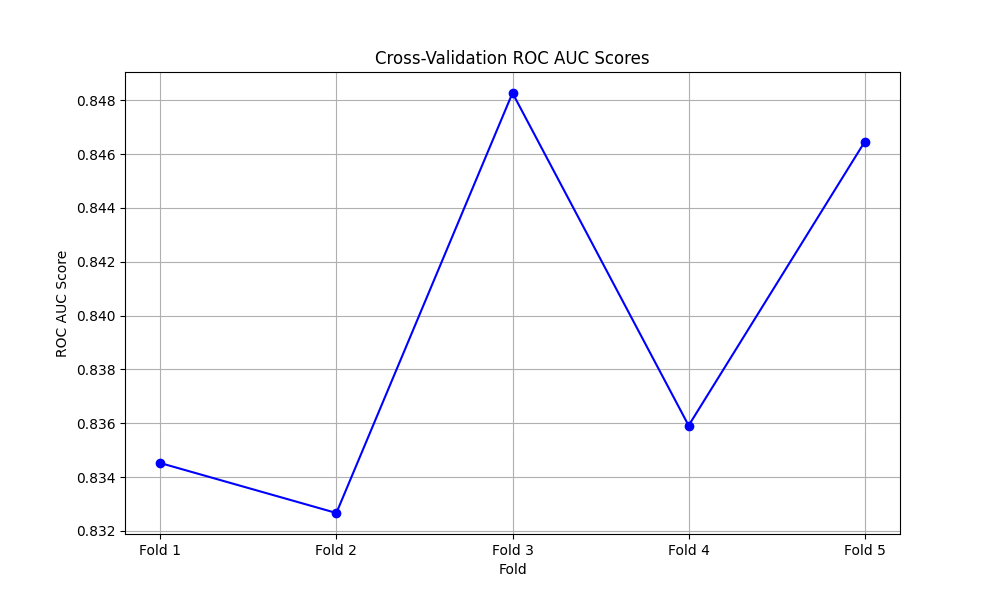

Standard Deviation of Cross-validation Scores: 0.006479057334851041


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, cross_val_score
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, roc_curve, auc
from piml import Experiment
from piml.models import XGB2Classifier

# Initialize a PiML Experiment
exp = Experiment(highcode_only=True)

# Load data, exclude demographic features, and perform train-test split
data_url = "https://github.com/SelfExplainML/PiML-Toolbox/blob/main/datasets/SimuCredit_v2.csv?raw=true"
data = pd.read_csv(data_url)
exp.data_loader(data=data, silent=True)
exp.data_summary(feature_exclude=["Gender", "Race"], silent=True)
exp.data_prepare(test_ratio=0.2, random_state=0, silent=True)

# Retrieve training and test data
train_x, train_y, _ = exp.get_data(train=True)
test_x, test_y, _ = exp.get_data(test=True)

# Optionally, create a validation set from the training data
train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=0.1, random_state=0)

# Instantiate the XGB2 model
model = XGB2Classifier(n_estimators=5000, eta=0.05)

# Function to plot learning curves
def plot_learning_curves(model, X, y, train_sizes=np.linspace(0.1, 1.0, 10)):
    train_sizes, train_scores, validation_scores = learning_curve(
        model, X, y, train_sizes=train_sizes, cv=5, scoring='roc_auc')

    train_scores_mean = np.mean(train_scores, axis=1)
    validation_scores_mean = np.mean(validation_scores, axis=1)

    plt.figure()
    plt.plot(train_sizes, train_scores_mean, label='Training score')
    plt.plot(train_sizes, validation_scores_mean, label='Validation score')
    plt.ylabel('ROC AUC')
    plt.xlabel('Training set size')
    plt.title('Learning curves')
    plt.legend()
    plt.show()

# Hyperparameter grid for regularization ('gamma') and 'max_depth'
hyperparameter_grid = {
    'gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5],
    'max_depth': [3, 4, 5, 6, 7, 8]
}

# GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(model, hyperparameter_grid, scoring='roc_auc', cv=5)
grid_search.fit(train_x, train_y)

# Best gamma and max_depth parameters
best_gamma = grid_search.best_params_['gamma']
best_max_depth = grid_search.best_params_['max_depth']
print("Best gamma (regularization):", best_gamma)
print("Best max_depth:", best_max_depth)

# Use the best model from GridSearchCV for further steps
model = grid_search.best_estimator_

# Plot learning curves using the tuned model
plot_learning_curves(model, train_x, train_y)

# Re-fit the model with the best regularization parameter
model = XGB2Classifier(n_estimators=5000, eta=0.05, gamma=best_gamma)
model.fit(train_x, train_y)

# Function to score the model
def score(model, train_x, train_y, test_x, test_y, valid_x, valid_y):
    train_auc = roc_auc_score(train_y, model.predict_proba(train_x)[:, 1])
    test_auc = roc_auc_score(test_y, model.predict_proba(test_x)[:, 1])
    valid_auc = roc_auc_score(valid_y, model.predict_proba(valid_x)[:, 1])

    # Access the underlying XGBoost booster
    booster = model.estimator_.get_booster()
    xgbinfo = booster.trees_to_dataframe()

    # Calculate the number of leaves
    n_leaves = np.sum(xgbinfo.loc[:, ["Feature"]].values == "Leaf")
    return {'train_auc': train_auc, 'test_auc': test_auc, 'valid_auc': valid_auc, 'n_leaves': n_leaves}

# Prepare for early stopping and data collection for plot
early_stopping_rounds = 50
best_iteration = 0
best_valid_auc = 0
all_metrics = []

# Iteratively evaluate model and implement manual early stopping
for i in range(5000):
    metrics = score(model, train_x, train_y, test_x, test_y, valid_x, valid_y)
    metrics['n_iteration'] = i + 1
    all_metrics.append(metrics)

    if metrics['valid_auc'] > best_valid_auc:
        best_valid_auc = metrics['valid_auc']
        best_iteration = i
    elif i - best_iteration > early_stopping_rounds:
        print(f"Early stopping at iteration {i}")
        break

# Evaluation on the test set
y_pred = model.predict(test_x)
y_pred_proba = model.predict_proba(test_x)[:, 1]

# Confusion matrix
cm = confusion_matrix(test_y, y_pred)
print("Confusion Matrix:\n", cm)

# Classification report for precision, recall, F1-score
print("\nClassification Report:\n", classification_report(test_y, y_pred))

# ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(test_y, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Plotting AUC over iterations
all_results = pd.DataFrame(all_metrics)
plt.figure(figsize=(8, 4))
plt.scatter(all_results["n_iteration"], all_results["train_auc"], color="blue", label="train")
plt.scatter(all_results["n_iteration"], all_results["test_auc"], color="red", label="test")
plt.scatter(all_results["n_iteration"], all_results["valid_auc"], color="green", label="validation")
plt.legend()
plt.ylabel("AUC")
plt.xlabel("Number of Iterations")
plt.show()

# Cross-validation scores
cross_val_scores = cross_val_score(model, train_x, train_y, cv=5, scoring='roc_auc')
print("Cross-validation ROC AUC scores:", cross_val_scores)

# Plotting the cross-validation scores
plt.figure(figsize=(10, 6))
plt.plot(cross_val_scores, marker='o', linestyle='-', color='b')
plt.title('Cross-Validation ROC AUC Scores')
plt.xlabel('Fold')
plt.ylabel('ROC AUC Score')
plt.xticks(range(len(cross_val_scores)), [f"Fold {i+1}" for i in range(len(cross_val_scores))])
plt.grid(True)
plt.show()

# Calculate and print the standard deviation of the cross-validation scores
std_dev = np.std(cross_val_scores)
print("Standard Deviation of Cross-validation Scores:", std_dev)

Best gamma (regularization): 0.1
Best max_depth: 5


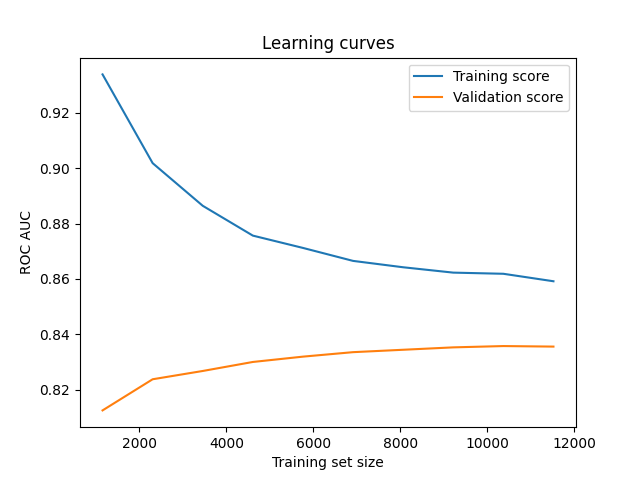

Early stopping at iteration 51
Confusion Matrix:
 [[1166  642]
 [ 374 1818]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.76      0.64      0.70      1808
         1.0       0.74      0.83      0.78      2192

    accuracy                           0.75      4000
   macro avg       0.75      0.74      0.74      4000
weighted avg       0.75      0.75      0.74      4000



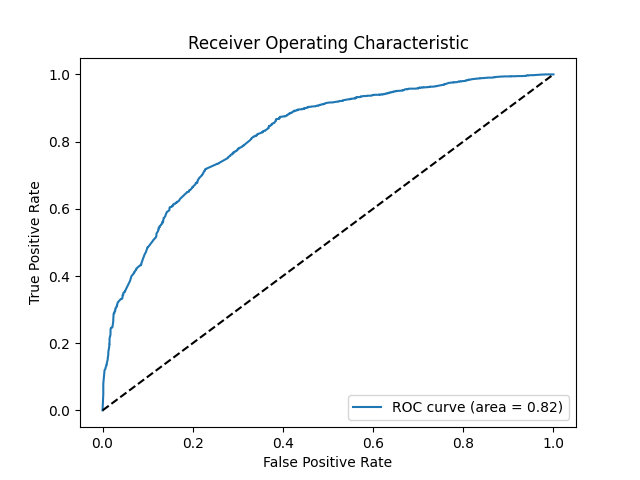

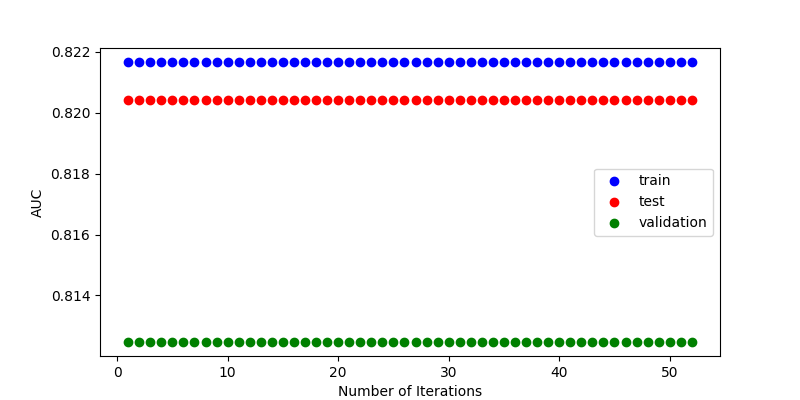

Cross-validation ROC AUC scores: [0.81854911 0.80870335 0.83105871 0.80852336 0.82494403]


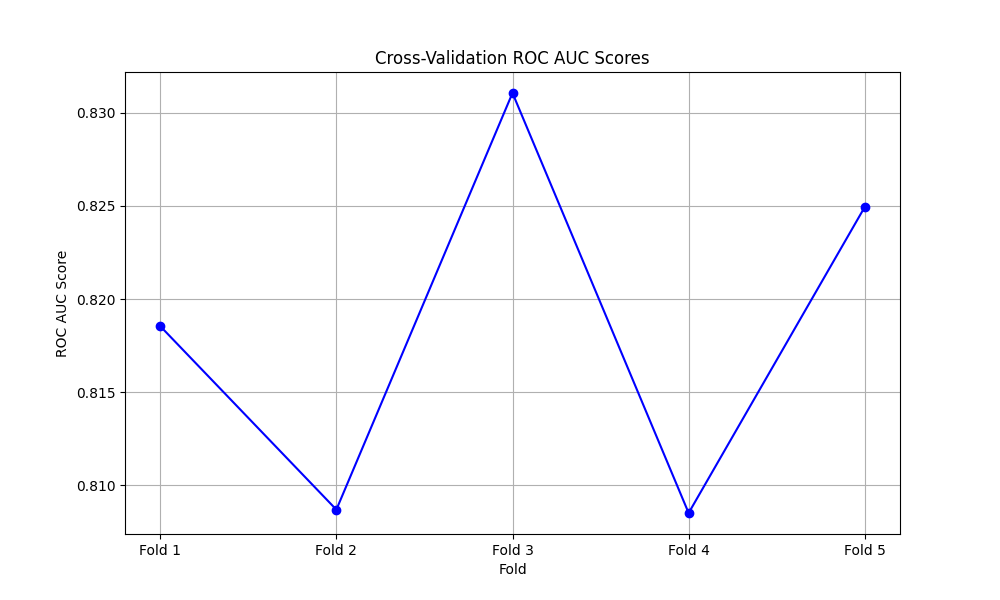

Standard Deviation of Cross-validation Scores: 0.00888428522097248


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, cross_val_score
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, roc_curve, auc
from piml import Experiment
from piml.models import XGB2Classifier

# Initialize a PiML Experiment
exp = Experiment(highcode_only=True)

# Load data, exclude demographic features, and perform train-test split
data_url = "https://github.com/SelfExplainML/PiML-Toolbox/blob/main/datasets/SimuCredit_v2.csv?raw=true"
data = pd.read_csv(data_url)
exp.data_loader(data=data, silent=True)
exp.data_summary(feature_exclude=["Gender", "Race"], silent=True)
exp.data_prepare(test_ratio=0.2, random_state=0, silent=True)

# Retrieve training and test data
train_x, train_y, _ = exp.get_data(train=True)
test_x, test_y, _ = exp.get_data(test=True)

# Optionally, create a validation set from the training data
train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=0.1, random_state=0)

# Instantiate the XGB2 model
model = XGB2Classifier(n_estimators=5000, eta=0.0005)

# Function to plot learning curves
def plot_learning_curves(model, X, y, train_sizes=np.linspace(0.1, 1.0, 10)):
    train_sizes, train_scores, validation_scores = learning_curve(
        model, X, y, train_sizes=train_sizes, cv=5, scoring='roc_auc')

    train_scores_mean = np.mean(train_scores, axis=1)
    validation_scores_mean = np.mean(validation_scores, axis=1)

    plt.figure()
    plt.plot(train_sizes, train_scores_mean, label='Training score')
    plt.plot(train_sizes, validation_scores_mean, label='Validation score')
    plt.ylabel('ROC AUC')
    plt.xlabel('Training set size')
    plt.title('Learning curves')
    plt.legend()
    plt.show()

# Hyperparameter grid for regularization ('gamma') and 'max_depth'
hyperparameter_grid = {
    'gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5],
    'max_depth': [3, 4, 5, 6, 7, 8]
}

# GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(model, hyperparameter_grid, scoring='roc_auc', cv=5)
grid_search.fit(train_x, train_y)

# Best gamma and max_depth parameters
best_gamma = grid_search.best_params_['gamma']
best_max_depth = grid_search.best_params_['max_depth']
print("Best gamma (regularization):", best_gamma)
print("Best max_depth:", best_max_depth)

# Use the best model from GridSearchCV for further steps
model = grid_search.best_estimator_

# Plot learning curves using the tuned model
plot_learning_curves(model, train_x, train_y)

# Re-fit the model with the best regularization parameter
model = XGB2Classifier(n_estimators=5000, eta=0.0005, gamma=best_gamma)
model.fit(train_x, train_y)

# Function to score the model
def score(model, train_x, train_y, test_x, test_y, valid_x, valid_y):
    train_auc = roc_auc_score(train_y, model.predict_proba(train_x)[:, 1])
    test_auc = roc_auc_score(test_y, model.predict_proba(test_x)[:, 1])
    valid_auc = roc_auc_score(valid_y, model.predict_proba(valid_x)[:, 1])

    # Access the underlying XGBoost booster
    booster = model.estimator_.get_booster()
    xgbinfo = booster.trees_to_dataframe()

    # Calculate the number of leaves
    n_leaves = np.sum(xgbinfo.loc[:, ["Feature"]].values == "Leaf")
    return {'train_auc': train_auc, 'test_auc': test_auc, 'valid_auc': valid_auc, 'n_leaves': n_leaves}

# Prepare for early stopping and data collection for plot
early_stopping_rounds = 50
best_iteration = 0
best_valid_auc = 0
all_metrics = []

# Iteratively evaluate model and implement manual early stopping
for i in range(5000):
    metrics = score(model, train_x, train_y, test_x, test_y, valid_x, valid_y)
    metrics['n_iteration'] = i + 1
    all_metrics.append(metrics)

    if metrics['valid_auc'] > best_valid_auc:
        best_valid_auc = metrics['valid_auc']
        best_iteration = i
    elif i - best_iteration > early_stopping_rounds:
        print(f"Early stopping at iteration {i}")
        break

# Evaluation on the test set
y_pred = model.predict(test_x)
y_pred_proba = model.predict_proba(test_x)[:, 1]

# Confusion matrix
cm = confusion_matrix(test_y, y_pred)
print("Confusion Matrix:\n", cm)

# Classification report for precision, recall, F1-score
print("\nClassification Report:\n", classification_report(test_y, y_pred))

# ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(test_y, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Plotting AUC over iterations
all_results = pd.DataFrame(all_metrics)
plt.figure(figsize=(8, 4))
plt.scatter(all_results["n_iteration"], all_results["train_auc"], color="blue", label="train")
plt.scatter(all_results["n_iteration"], all_results["test_auc"], color="red", label="test")
plt.scatter(all_results["n_iteration"], all_results["valid_auc"], color="green", label="validation")
plt.legend()
plt.ylabel("AUC")
plt.xlabel("Number of Iterations")
plt.show()

# Cross-validation scores
cross_val_scores = cross_val_score(model, train_x, train_y, cv=5, scoring='roc_auc')
print("Cross-validation ROC AUC scores:", cross_val_scores)

# Plotting the cross-validation scores
plt.figure(figsize=(10, 6))
plt.plot(cross_val_scores, marker='o', linestyle='-', color='b')
plt.title('Cross-Validation ROC AUC Scores')
plt.xlabel('Fold')
plt.ylabel('ROC AUC Score')
plt.xticks(range(len(cross_val_scores)), [f"Fold {i+1}" for i in range(len(cross_val_scores))])
plt.grid(True)
plt.show()

# Calculate and print the standard deviation of the cross-validation scores
std_dev = np.std(cross_val_scores)
print("Standard Deviation of Cross-validation Scores:", std_dev)

Best gamma (regularization): 0.5
Best max_depth: 3


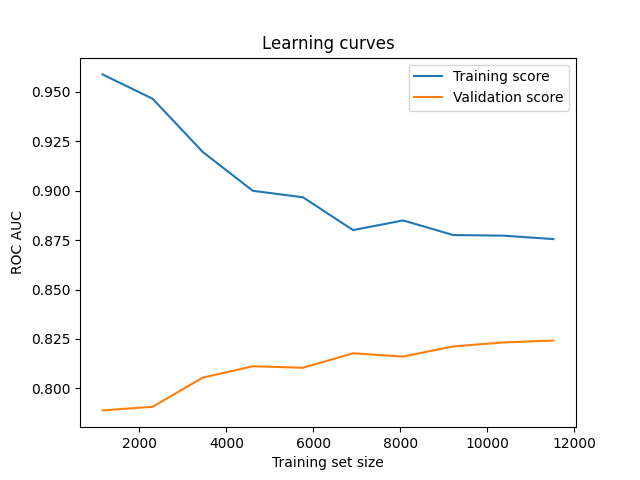

Early stopping at iteration 11
Confusion Matrix:
 [[1261  549]
 [ 404 1786]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.76      0.70      0.73      1810
         1.0       0.76      0.82      0.79      2190

    accuracy                           0.76      4000
   macro avg       0.76      0.76      0.76      4000
weighted avg       0.76      0.76      0.76      4000



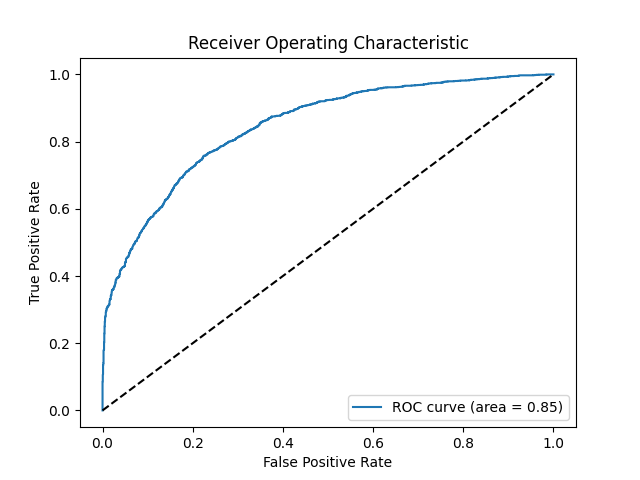

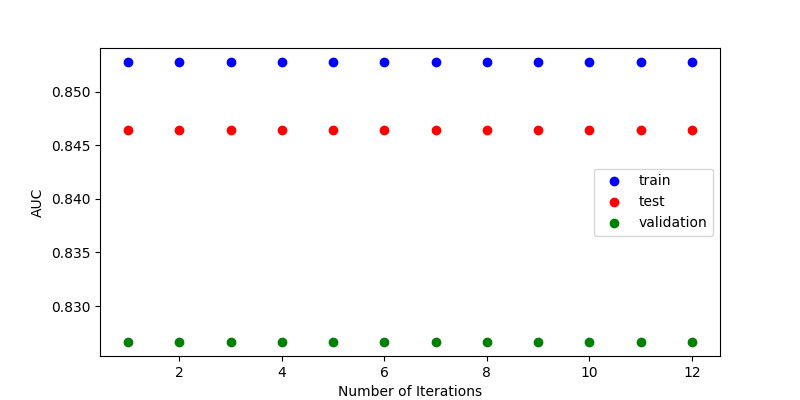

Cross-validation ROC AUC scores: [0.82903423 0.82242411 0.81758936 0.84299763 0.83922993]


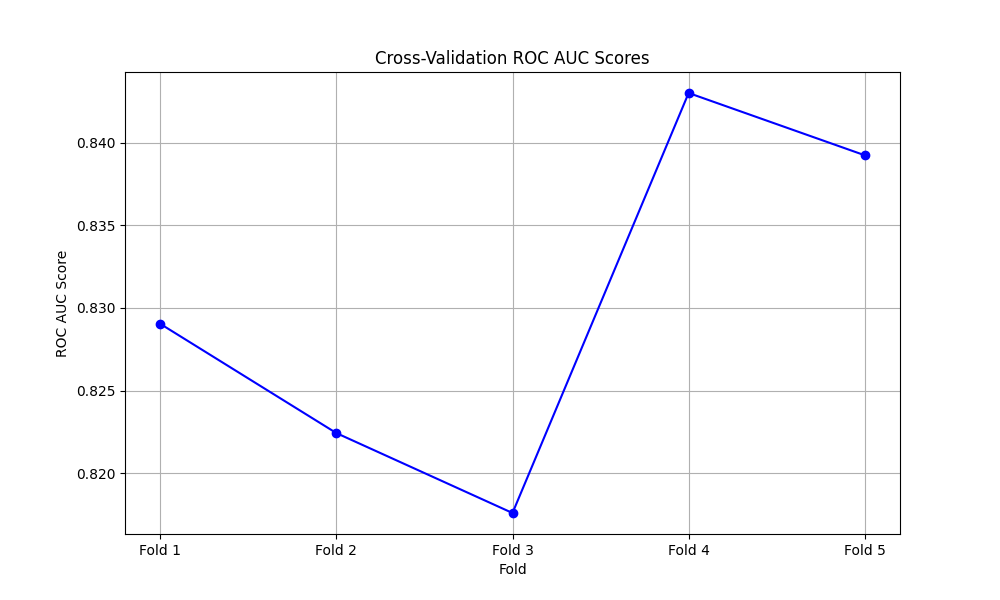

Standard Deviation of Cross-validation Scores: 0.009655624561209093


In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, cross_val_score
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, roc_curve, auc
from piml import Experiment
from piml.models import XGB2Classifier

# Initialize a PiML Experiment
exp = Experiment(highcode_only=True)

# Load data, exclude demographic features, and perform train-test split
data_url = "https://github.com/SelfExplainML/PiML-Toolbox/blob/main/datasets/SimuCredit_v2.csv?raw=true"
data = pd.read_csv(data_url)
exp.data_loader(data=data, silent=True)
exp.data_summary(feature_exclude=["Gender", "Race"], silent=True)
exp.data_prepare(test_ratio=0.2, random_state=1, silent=True)

# Retrieve training and test data
train_x, train_y, _ = exp.get_data(train=True)
test_x, test_y, _ = exp.get_data(test=True)

# Optionally, create a validation set from the training data
train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=0.1, random_state=1)

# Instantiate the XGB2 model
model = XGB2Classifier(n_estimators=5000, eta=0.8)

# Function to plot learning curves
def plot_learning_curves(model, X, y, train_sizes=np.linspace(0.1, 1.0, 10)):
    train_sizes, train_scores, validation_scores = learning_curve(
        model, X, y, train_sizes=train_sizes, cv=5, scoring='roc_auc')

    train_scores_mean = np.mean(train_scores, axis=1)
    validation_scores_mean = np.mean(validation_scores, axis=1)

    plt.figure()
    plt.plot(train_sizes, train_scores_mean, label='Training score')
    plt.plot(train_sizes, validation_scores_mean, label='Validation score')
    plt.ylabel('ROC AUC')
    plt.xlabel('Training set size')
    plt.title('Learning curves')
    plt.legend()
    plt.show()

# Hyperparameter grid for regularization ('gamma') and 'max_depth'
hyperparameter_grid = {
    'gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5],
    'max_depth': [3, 4, 5, 6, 7, 8]
}

# GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(model, hyperparameter_grid, scoring='roc_auc', cv=3)
grid_search.fit(train_x, train_y)

# Best gamma and max_depth parameters
best_gamma = grid_search.best_params_['gamma']
best_max_depth = grid_search.best_params_['max_depth']
print("Best gamma (regularization):", best_gamma)
print("Best max_depth:", best_max_depth)

# Use the best model from GridSearchCV for further steps
model = grid_search.best_estimator_

# Plot learning curves using the tuned model
plot_learning_curves(model, train_x, train_y)

# Re-fit the model with the best regularization parameter
model = XGB2Classifier(n_estimators=5000, eta=0.8, gamma=best_gamma)
model.fit(train_x, train_y)

# Function to score the model
def score(model, train_x, train_y, test_x, test_y, valid_x, valid_y):
    train_auc = roc_auc_score(train_y, model.predict_proba(train_x)[:, 1])
    test_auc = roc_auc_score(test_y, model.predict_proba(test_x)[:, 1])
    valid_auc = roc_auc_score(valid_y, model.predict_proba(valid_x)[:, 1])

    # Access the underlying XGBoost booster
    booster = model.estimator_.get_booster()
    xgbinfo = booster.trees_to_dataframe()

    # Calculate the number of leaves
    n_leaves = np.sum(xgbinfo.loc[:, ["Feature"]].values == "Leaf")
    return {'train_auc': train_auc, 'test_auc': test_auc, 'valid_auc': valid_auc, 'n_leaves': n_leaves}

# Prepare for early stopping and data collection for plot
early_stopping_rounds = 10
best_iteration = 0
best_valid_auc = 0
all_metrics = []

# Iteratively evaluate model and implement manual early stopping
for i in range(5000):
    metrics = score(model, train_x, train_y, test_x, test_y, valid_x, valid_y)
    metrics['n_iteration'] = i + 1
    all_metrics.append(metrics)

    if metrics['valid_auc'] > best_valid_auc:
        best_valid_auc = metrics['valid_auc']
        best_iteration = i
    elif i - best_iteration > early_stopping_rounds:
        print(f"Early stopping at iteration {i}")
        break

# Evaluation on the test set
y_pred = model.predict(test_x)
y_pred_proba = model.predict_proba(test_x)[:, 1]

# Confusion matrix
cm = confusion_matrix(test_y, y_pred)
print("Confusion Matrix:\n", cm)

# Classification report for precision, recall, F1-score
print("\nClassification Report:\n", classification_report(test_y, y_pred))

# ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(test_y, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Plotting AUC over iterations
all_results = pd.DataFrame(all_metrics)
plt.figure(figsize=(8, 4))
plt.scatter(all_results["n_iteration"], all_results["train_auc"], color="blue", label="train")
plt.scatter(all_results["n_iteration"], all_results["test_auc"], color="red", label="test")
plt.scatter(all_results["n_iteration"], all_results["valid_auc"], color="green", label="validation")
plt.legend()
plt.ylabel("AUC")
plt.xlabel("Number of Iterations")
plt.show()

# Cross-validation scores
cross_val_scores = cross_val_score(model, train_x, train_y, cv=5, scoring='roc_auc')
print("Cross-validation ROC AUC scores:", cross_val_scores)

# Plotting the cross-validation scores
plt.figure(figsize=(10, 6))
plt.plot(cross_val_scores, marker='o', linestyle='-', color='b')
plt.title('Cross-Validation ROC AUC Scores')
plt.xlabel('Fold')
plt.ylabel('ROC AUC Score')
plt.xticks(range(len(cross_val_scores)), [f"Fold {i+1}" for i in range(len(cross_val_scores))])
plt.grid(True)
plt.show()

# Calculate and print the standard deviation of the cross-validation scores
std_dev = np.std(cross_val_scores)
print("Standard Deviation of Cross-validation Scores:", std_dev)

Best gamma (regularization): 0.5
Best max_depth: 3


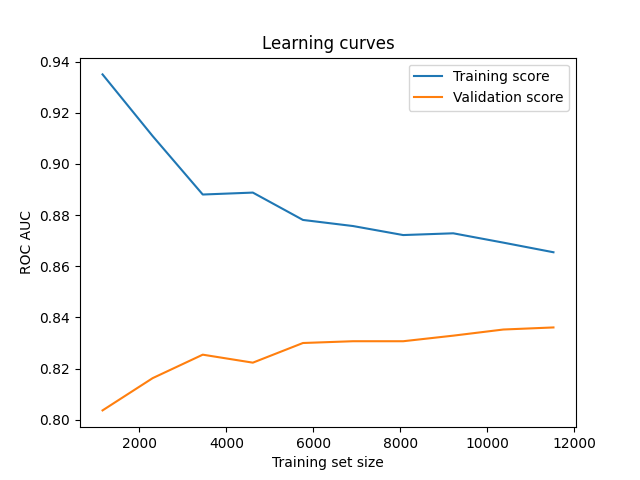

Early stopping at iteration 201
Confusion Matrix:
 [[1286  522]
 [ 418 1774]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.75      0.71      0.73      1808
         1.0       0.77      0.81      0.79      2192

    accuracy                           0.77      4000
   macro avg       0.76      0.76      0.76      4000
weighted avg       0.76      0.77      0.76      4000



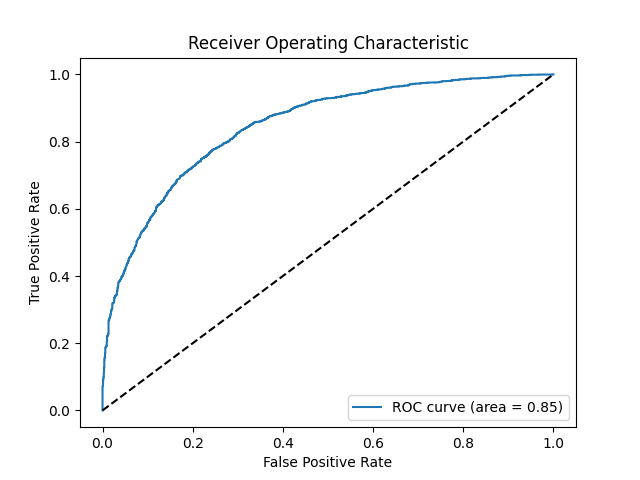

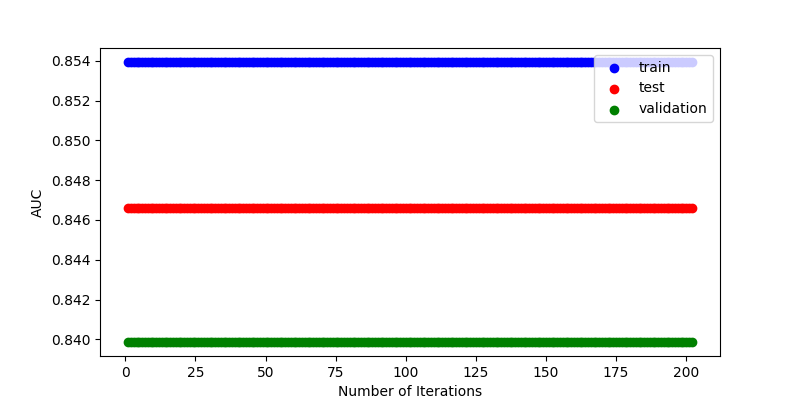

Cross-validation ROC AUC scores: [0.83331823 0.83014413 0.84502237 0.83424864 0.84444685]


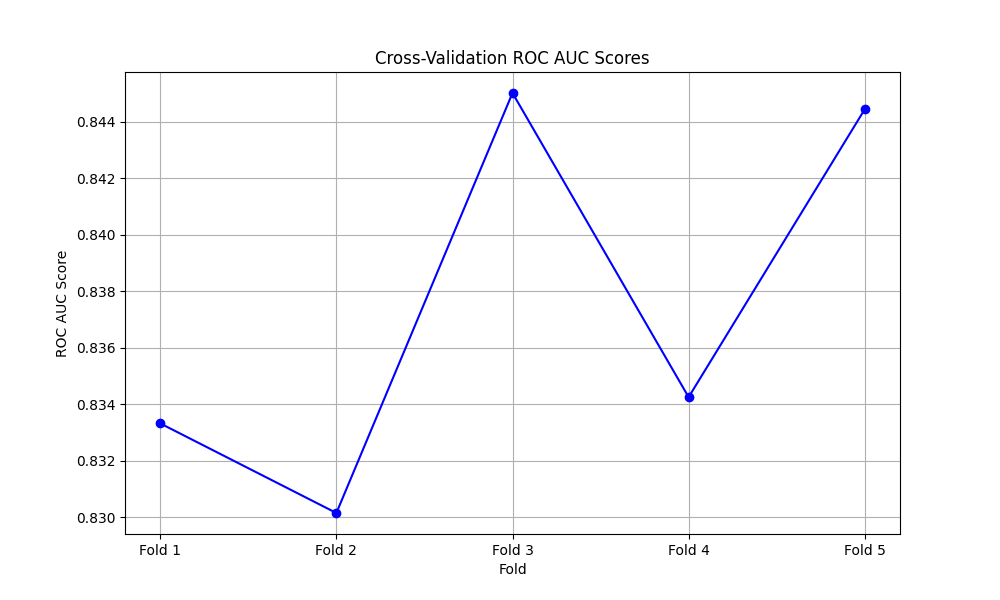

Standard Deviation of Cross-validation Scores: 0.006115418086693505


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve, cross_val_score
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report, roc_curve, auc
from piml import Experiment
from piml.models import XGB2Classifier

# Initialize a PiML Experiment
exp = Experiment(highcode_only=True)

# Load data, exclude demographic features, and perform train-test split
data_url = "https://github.com/SelfExplainML/PiML-Toolbox/blob/main/datasets/SimuCredit_v2.csv?raw=true"
data = pd.read_csv(data_url)
exp.data_loader(data=data, silent=True)
exp.data_summary(feature_exclude=["Gender", "Race"], silent=True)
exp.data_prepare(test_ratio=0.2, random_state=0, silent=True)

# Retrieve training and test data
train_x, train_y, _ = exp.get_data(train=True)
test_x, test_y, _ = exp.get_data(test=True)

# Optionally, create a validation set from the training data
train_x, valid_x, train_y, valid_y = train_test_split(train_x, train_y, test_size=0.1, random_state=0)

# Instantiate the XGB2 model
model = XGB2Classifier(n_estimators=10000, eta=0.5)

# Function to plot learning curves
def plot_learning_curves(model, X, y, train_sizes=np.linspace(0.1, 1.0, 10)):
    train_sizes, train_scores, validation_scores = learning_curve(
        model, X, y, train_sizes=train_sizes, cv=5, scoring='roc_auc')

    train_scores_mean = np.mean(train_scores, axis=1)
    validation_scores_mean = np.mean(validation_scores, axis=1)

    plt.figure()
    plt.plot(train_sizes, train_scores_mean, label='Training score')
    plt.plot(train_sizes, validation_scores_mean, label='Validation score')
    plt.ylabel('ROC AUC')
    plt.xlabel('Training set size')
    plt.title('Learning curves')
    plt.legend()
    plt.show()

# Hyperparameter grid for regularization ('gamma') and 'max_depth'
hyperparameter_grid = {
    'gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5],
    'max_depth': [3, 4, 5, 6, 7, 8]
}

# GridSearchCV for hyperparameter tuning
grid_search = GridSearchCV(model, hyperparameter_grid, scoring='roc_auc', cv=5)
grid_search.fit(train_x, train_y)

# Best gamma and max_depth parameters
best_gamma = grid_search.best_params_['gamma']
best_max_depth = grid_search.best_params_['max_depth']
print("Best gamma (regularization):", best_gamma)
print("Best max_depth:", best_max_depth)

# Use the best model from GridSearchCV for further steps
model = grid_search.best_estimator_

# Plot learning curves using the tuned model
plot_learning_curves(model, train_x, train_y)

# Re-fit the model with the best regularization parameter
model = XGB2Classifier(n_estimators=10000, eta=0.5, gamma=best_gamma)
model.fit(train_x, train_y)

# Function to score the model
def score(model, train_x, train_y, test_x, test_y, valid_x, valid_y):
    train_auc = roc_auc_score(train_y, model.predict_proba(train_x)[:, 1])
    test_auc = roc_auc_score(test_y, model.predict_proba(test_x)[:, 1])
    valid_auc = roc_auc_score(valid_y, model.predict_proba(valid_x)[:, 1])

    # Access the underlying XGBoost booster
    booster = model.estimator_.get_booster()
    xgbinfo = booster.trees_to_dataframe()

    # Calculate the number of leaves
    n_leaves = np.sum(xgbinfo.loc[:, ["Feature"]].values == "Leaf")
    return {'train_auc': train_auc, 'test_auc': test_auc, 'valid_auc': valid_auc, 'n_leaves': n_leaves}

# Prepare for early stopping and data collection for plot
early_stopping_rounds = 200
best_iteration = 0
best_valid_auc = 0
all_metrics = []

# Iteratively evaluate model and implement manual early stopping
for i in range(10000):
    metrics = score(model, train_x, train_y, test_x, test_y, valid_x, valid_y)
    metrics['n_iteration'] = i + 1
    all_metrics.append(metrics)

    if metrics['valid_auc'] > best_valid_auc:
        best_valid_auc = metrics['valid_auc']
        best_iteration = i
    elif i - best_iteration > early_stopping_rounds:
        print(f"Early stopping at iteration {i}")
        break

# Evaluation on the test set
y_pred = model.predict(test_x)
y_pred_proba = model.predict_proba(test_x)[:, 1]

# Confusion matrix
cm = confusion_matrix(test_y, y_pred)
print("Confusion Matrix:\n", cm)

# Classification report for precision, recall, F1-score
print("\nClassification Report:\n", classification_report(test_y, y_pred))

# ROC Curve and AUC
fpr, tpr, thresholds = roc_curve(test_y, y_pred_proba)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Dashed diagonal
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Plotting AUC over iterations
all_results = pd.DataFrame(all_metrics)
plt.figure(figsize=(8, 4))
plt.scatter(all_results["n_iteration"], all_results["train_auc"], color="blue", label="train")
plt.scatter(all_results["n_iteration"], all_results["test_auc"], color="red", label="test")
plt.scatter(all_results["n_iteration"], all_results["valid_auc"], color="green", label="validation")
plt.legend()
plt.ylabel("AUC")
plt.xlabel("Number of Iterations")
plt.show()

# Cross-validation scores
cross_val_scores = cross_val_score(model, train_x, train_y, cv=5, scoring='roc_auc')
print("Cross-validation ROC AUC scores:", cross_val_scores)

# Plotting the cross-validation scores
plt.figure(figsize=(10, 6))
plt.plot(cross_val_scores, marker='o', linestyle='-', color='b')
plt.title('Cross-Validation ROC AUC Scores')
plt.xlabel('Fold')
plt.ylabel('ROC AUC Score')
plt.xticks(range(len(cross_val_scores)), [f"Fold {i+1}" for i in range(len(cross_val_scores))])
plt.grid(True)
plt.show()

# Calculate and print the standard deviation of the cross-validation scores
std_dev = np.std(cross_val_scores)
print("Standard Deviation of Cross-validation Scores:", std_dev)